In [1]:
import os
import re
import numpy as np
import soundfile as sf
import librosa 
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#For PCA & KNN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

#For KNN - SVM 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC  # Support Vector Classifier

#For NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import pytorch_lightning as pl  
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import tensorboard
from torch.utils.data import Dataset, DataLoader


# Functions definition

These function will be used for feature computation. For MFCC we consider 40 mel filters and keep only the first 13, as a standard procedure. According to sample rate and speech quasi-stationarity, the window length has be set to 512 leading to windows of 32 ms.  
Classification between Male and Female voice might use the help of the average fundamental, that is generally distinctive. 

In [2]:
def compute_mfcc(audio, fs, n_mfcc): 
    #win_len = 512 --> 32 ms -- Hamming for spectral leakage
    X = np.abs(librosa.stft(audio, window = 'hamming', n_fft = 512, hop_length=256))
    #Length of window considers the quasi-stationarity of speech 
    #fundamentals males : 80 Hz - females : 165 Hz
    mel_filters = librosa.filters.mel(sr = samplerate, n_fft = 512, n_mels = 40, fmin = 50, fmax = 8000)
    
    mel_spectrum = np.dot(mel_filters, X) 
    log_melspectrogram = np.log10(mel_spectrum+ 1e-16)
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    #Shape mfcc : n_mfcc x nb_frames
    return mfcc 



def compute_average_fund(audio, samplerate): 
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=50, fmax=500, sr=samplerate, hop_length=256)

    if np.all(np.isnan(f0)):  
        avg_f0 = 0  # or set to a default value like 0
        print("Warning: f0 contains only NaN values.")
        
    else:
        avg_f0 = np.nanmean(f0)
    
    
    
    return avg_f0
    

    

# Dataframe definition

Since the dev-clean subset contains a subset of the speakers of the whole LibriSpeech dataset, in this cell the gender of the speakers contained in the subset are extracted using: 
* comprehensive annotations in SPEAKERS.TXT
* The name of the folders in the subset.

In [16]:

annotations = open('LibriSpeech/SPEAKERS.TXT')
lines = annotations.readlines()
subset_ids = os.listdir('LibriSpeech/dev-clean')
tot_speakers_id_sex = []
for elem in lines: 
    if elem[0] != ';': 
        speaker_id_sex = elem.split('|')[0:2]
        speaker_id_sex[0] = speaker_id_sex[0].replace(" ", "")
        speaker_id_sex[1] = speaker_id_sex[1].replace(" ", "")
        #This list of lists contains the id and the associated sex of all speakers in the dataset. 
        tot_speakers_id_sex.append(speaker_id_sex)

#Filter the speakers inside subset

subset_annotations = [elem for elem in tot_speakers_id_sex if elem[0] in subset_ids]
print("subset_annotations:\n", subset_annotations, "\nLen subset_annotations:", len(subset_annotations))


subset_annotations:
 [['84', 'F'], ['174', 'M'], ['251', 'M'], ['422', 'M'], ['652', 'M'], ['777', 'M'], ['1272', 'M'], ['1462', 'F'], ['1673', 'F'], ['1919', 'F'], ['1988', 'F'], ['1993', 'F'], ['2035', 'F'], ['2078', 'M'], ['2086', 'M'], ['2277', 'F'], ['2412', 'F'], ['2428', 'M'], ['2803', 'M'], ['2902', 'M'], ['3000', 'M'], ['3081', 'F'], ['3170', 'M'], ['3536', 'F'], ['3576', 'F'], ['3752', 'M'], ['3853', 'F'], ['5338', 'F'], ['5536', 'M'], ['5694', 'M'], ['5895', 'F'], ['6241', 'M'], ['6295', 'M'], ['6313', 'F'], ['6319', 'F'], ['6345', 'F'], ['7850', 'F'], ['7976', 'M'], ['8297', 'M'], ['8842', 'F']] 
Len subset_annotations: 40


## Visualization of Test audios 
Four test audio files are represented in time-frequency domain. The results show the higher harmonic content in female related audios. 

test samples list ['f2.flac', 'm2.flac', 'm1.flac', 'f1.flac', '.ipynb_checkpoints']
audio shape (168160,)
audio shape (142240,)
audio shape (160960,)
audio shape (33440,)


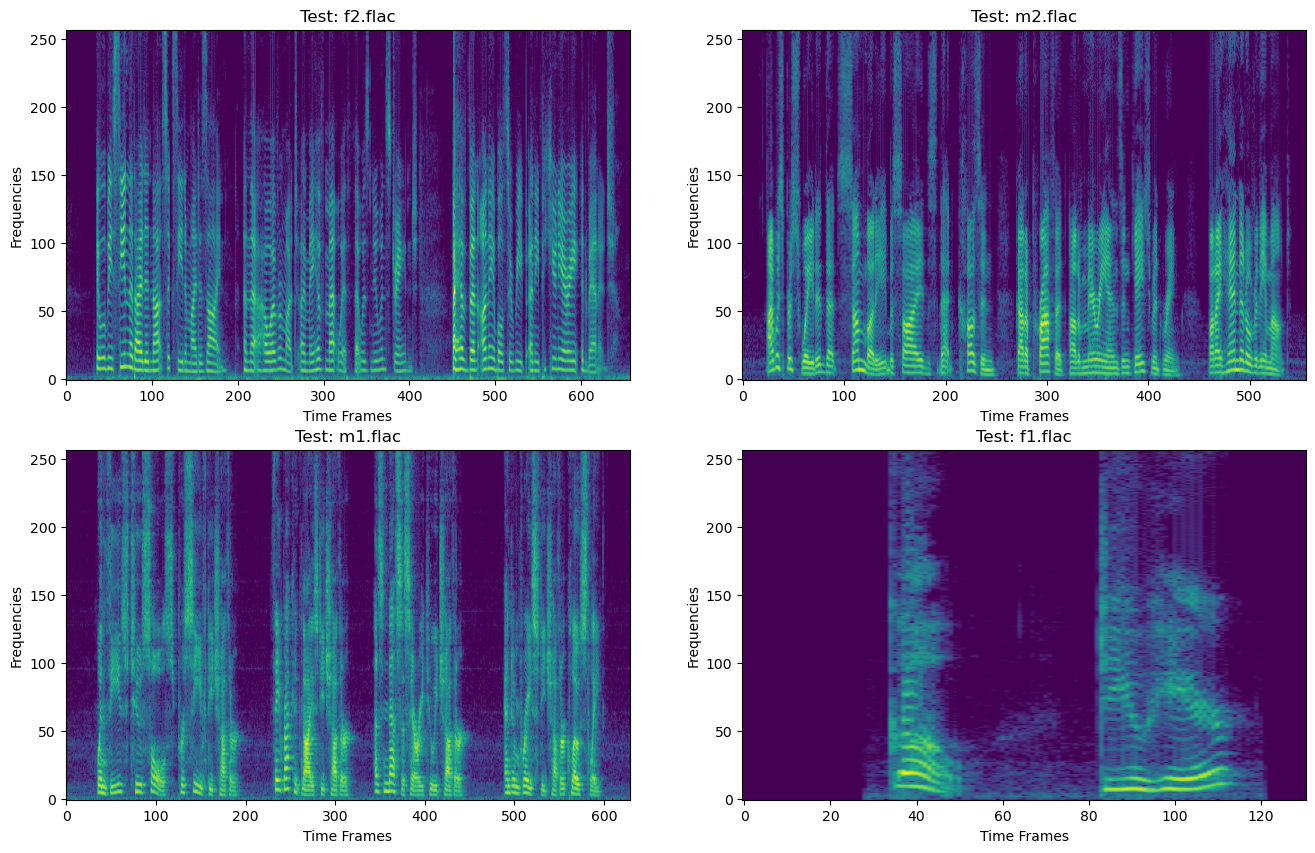

In [17]:
#Visualization F - M Speech
test_path = "test"
test_samples = os.listdir(test_path)
print("test samples list", test_samples)
fig1 = plt.figure(figsize=(16, 10))
for idx in range(0, len(test_samples)): 
    test_sample_path = os.path.join(test_path, test_samples[idx])
    if test_sample_path[-5:]==".flac":
        audio, samplerate = sf.read(test_sample_path)
        print("audio shape", audio.shape)
        f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=50, fmax=500, sr=samplerate, hop_length=256)
        avg_f0 = np.nanmean(f0)
        
        X = librosa.amplitude_to_db(np.abs(librosa.stft(audio, window='hamming', n_fft=512, hop_length=256)), ref=np.max)
        
        ax1 = plt.subplot(2,2,idx+1)
        c_ax1 = plt.imshow(X, origin='lower', aspect='auto')
        ax1.set_xlabel('Time Frames')
        ax1.set_ylabel('Frequencies')
        ax1.set_title('Test: ' + test_samples[idx])

plt.show()



## Definition of Dataframe holding dataset
A dataframe is generated, holding in its columns speaker_id, sex, mfcc data (and average fundamental per audio sample). The average fundamental was calculated because it could be a good and easy feature to differentiate between Male and Female speech. Anyway, it has been excluded from the calculation due to its time consumption. You are free to perform the computation by setting *f0_comp* variable to **True**.


In [18]:
#Initialize df columns
root_path = "LibriSpeech/dev-clean"
columns = ["speaker_id", "sex", "mfcc", "f0"]
#n_mfcc sub_col = [mfcc1, mfcc2, mfcc3 .... ]
f0_comp = False
rows_list = []
n_mfcc = 13



#------------------------------------#

#Iterating over the dev-clean folder
for fold in subset_ids: 
    path_id = os.path.join(root_path, fold)
    id_sex = [elem for elem in subset_annotations if elem[0]==fold][0]
    #extracting the corresponding speaker id and sex from subset_annotations
    for subfold in os.listdir(path_id):
        subfold_path = os.path.join(path_id, subfold)
        #iterating over the capters
        for n_audio in os.listdir(subfold_path):
            #Finally iterating over audio files
            if n_audio[-5:] == ".flac":
                print("Processing audio", n_audio)
                #inside these folders there are also the transcriptions. We're discarding them 
                audio_path = os.path.join(subfold_path, n_audio)
                audio, samplerate = sf.read(audio_path)

                audio_mfcc = compute_mfcc(audio, samplerate, n_mfcc)
                
                #For each audio file we collect the - speaker id, -sex, -mfcc. We create a list of dictionaries, to be used for dataframe creation. 
                #Iteratevily adding rows                        
                #row = {'speaker_id': id_sex[0], 'sex': id_sex[1], 'mfcc': audio_mfcc, 'f0': f0}
                if f0_comp: 
                    f0 = compute_average_fund(audio, samplerate)
                    row = {'speaker_id': id_sex[0], 'sex': id_sex[1], 'mfcc': audio_mfcc, 'f0': f0}
                else: 
                    row = {'speaker_id': id_sex[0], 'sex': id_sex[1], 'mfcc': audio_mfcc}

                rows_list.append(row)      


#Visualizing dataframe
dataframe_mfcc = pd.DataFrame(rows_list, columns=columns)




Processing audio 7850-73752-0004.flac
Processing audio 7850-73752-0011.flac
Processing audio 7850-73752-0000.flac
Processing audio 7850-73752-0001.flac
Processing audio 7850-73752-0016.flac
Processing audio 7850-73752-0009.flac
Processing audio 7850-73752-0008.flac
Processing audio 7850-73752-0015.flac
Processing audio 7850-73752-0014.flac
Processing audio 7850-73752-0002.flac
Processing audio 7850-73752-0003.flac
Processing audio 7850-73752-0018.flac
Processing audio 7850-73752-0013.flac
Processing audio 7850-73752-0007.flac
Processing audio 7850-73752-0010.flac
Processing audio 7850-73752-0019.flac
Processing audio 7850-73752-0017.flac
Processing audio 7850-73752-0005.flac
Processing audio 7850-73752-0012.flac
Processing audio 7850-73752-0006.flac
Processing audio 7850-286674-0005.flac
Processing audio 7850-286674-0011.flac
Processing audio 7850-286674-0004.flac
Processing audio 7850-286674-0017.flac
Processing audio 7850-286674-0013.flac
Processing audio 7850-286674-0006.flac
Proces

# Grouping per speaker
A new dataframe is generated, where mfcc data and average fundamental are grouped per speaker. This is done in order to perform some statistics depending on the speaker.
**For baseline classifiers and simple NN, features are averaged over time.** Dataframe for this purpouse is called *speakers_flat*.  
Each row contains the id of the speaker, its gender, a matrix (N_samples x n_mfcc) containing mfcc related to a specific speaker (each sample is averaged over time), and the array f0 holding all the averaged fundamental for that sample. This structure of the dataframe allows to perform speaker-related processing, statistics and data visualization. F0 can be very useful to detect outliers and see data distruibution. 
The *speakers_flat* dataframe has four columns : **speaker_id, sex, mfcc and f0**. 

In [21]:
#Dataframe holding the UNIQUE SPEAKERS ID and their sex
speakers_flat = list(set(dataframe_mfcc["speaker_id"]))
#40 different speakers
speakers_flat = dataframe_mfcc.drop_duplicates(subset='speaker_id')[["speaker_id", "sex"]]
f_speakers_nb = len(speakers_flat[speakers_flat["sex"]=='F'])
m_speakers_nb = len(speakers_flat[speakers_flat["sex"]=='M'])
tot_speakers_nb = len(speakers_flat)
print("Number of female speakers", f_speakers_nb, "\nNumber of male speakers", m_speakers_nb, "\nTotal number of speakers", tot_speakers_nb)

speakers_flat["mfcc"] = [[[]] for i in range(0, len(speakers_flat))]
speakers_flat["f0"] = [[] for i in range(0, len(speakers_flat))]


Number of female speakers 20 
Number of male speakers 20 
Total number of speakers 40


In [22]:
def get_mfcc_matrix_mean(mfcc_list, n_mfcc): 
    mfcc_matrix = np.zeros((len(mfcc_list), n_mfcc))
    for s_idx in range(0, len(mfcc_list)): 
        sample = np.mean(mfcc_list[s_idx], axis=1)
        mfcc_matrix[s_idx, :] = sample

    return mfcc_matrix

        
n_mfcc=13
#How are data distribuited for different speakers? 

speakers_list = speakers_flat["speaker_id"].tolist()


for s in speakers_list: 
    mfcc_samples_speaker = dataframe_mfcc[dataframe_mfcc["speaker_id"]==s]["mfcc"].to_list()
    mfcc_matrix = get_mfcc_matrix_mean(mfcc_samples_speaker, n_mfcc)
    f0_speaker = dataframe_mfcc[dataframe_mfcc["speaker_id"]==s]["f0"].to_numpy()
    cond_idx = speakers_flat[speakers_flat["speaker_id"] == s ].index[0]
    speakers_flat["mfcc"] = speakers_flat["mfcc"].astype('object')
    speakers_flat.at[cond_idx,'mfcc'] =  mfcc_matrix
    speakers_flat.at[cond_idx, 'f0'] =  f0_speaker
    #print("After assignement: how many samples for ", s, " Speaker : ", speakers.at[cond_idx,'mfcc'])





Here, outlier detection is performed exploiting Isolation Forest algorithm since it is known to be the fastest in a multi-dimensional features scenario. Outlier detection is performed per speaker. The logs show how many samples are delated by the algorithms. 

In [23]:
#Outlier detection x speaker. What is abnormal for one speaker might be ok for another, so outlier detection should be done for different speakers !
#Using Isolation Forest - 
for s in speakers_list:
    
    condition_index = speakers_flat[speakers_flat["speaker_id"] == s ].index[0]
    data_mfcc = speakers_flat.at[condition_index, "mfcc"]
    data_f0 = speakers_flat.at[condition_index, "f0"]
    #Standardization
    z_scaler_s = StandardScaler()
    #Z scaler for training set including outliers
    norm_data = z_scaler_s.fit_transform(data_mfcc)
    model_if = IsolationForest(contamination=0.1, random_state=42) 
    outliers_s = model_if.fit_predict(norm_data)        
    # Extract outlier samples
    print("Shape before isolation forest", norm_data.shape)
    outlier_indices_s = np.where(outliers_s == -1)[0]
    clean_data_mfcc = np.delete(data_mfcc, outlier_indices_s, axis = 0)
    clean_data_f0 = np.delete(data_f0, outlier_indices_s, axis = 0)
    print("shape after isolation forest", clean_data_mfcc.shape, "\n")
    speakers_flat.at[condition_index, "mfcc"] = clean_data_mfcc
    speakers_flat.at[condition_index, "f0"] = clean_data_f0
    
    #


Shape before isolation forest (72, 13)
shape after isolation forest (64, 13) 

Shape before isolation forest (49, 13)
shape after isolation forest (44, 13) 

Shape before isolation forest (96, 13)
shape after isolation forest (86, 13) 

Shape before isolation forest (78, 13)
shape after isolation forest (70, 13) 

Shape before isolation forest (58, 13)
shape after isolation forest (52, 13) 

Shape before isolation forest (71, 13)
shape after isolation forest (64, 13) 

Shape before isolation forest (64, 13)
shape after isolation forest (57, 13) 

Shape before isolation forest (36, 13)
shape after isolation forest (32, 13) 

Shape before isolation forest (59, 13)
shape after isolation forest (53, 13) 

Shape before isolation forest (82, 13)
shape after isolation forest (73, 13) 

Shape before isolation forest (41, 13)
shape after isolation forest (37, 13) 

Shape before isolation forest (75, 13)
shape after isolation forest (67, 13) 

Shape before isolation forest (78, 13)
shape after i

# PCA analysis 
PCA analysis allows to understand data distribution over components that maximize feature variance. Here it can be observed that data distribuition for the two classes present a consistent overlapping.

[0.23289887 0.13465066]
(2703, 2)
Labels ['$\\mathdefault{0}$', '$\\mathdefault{1}$']


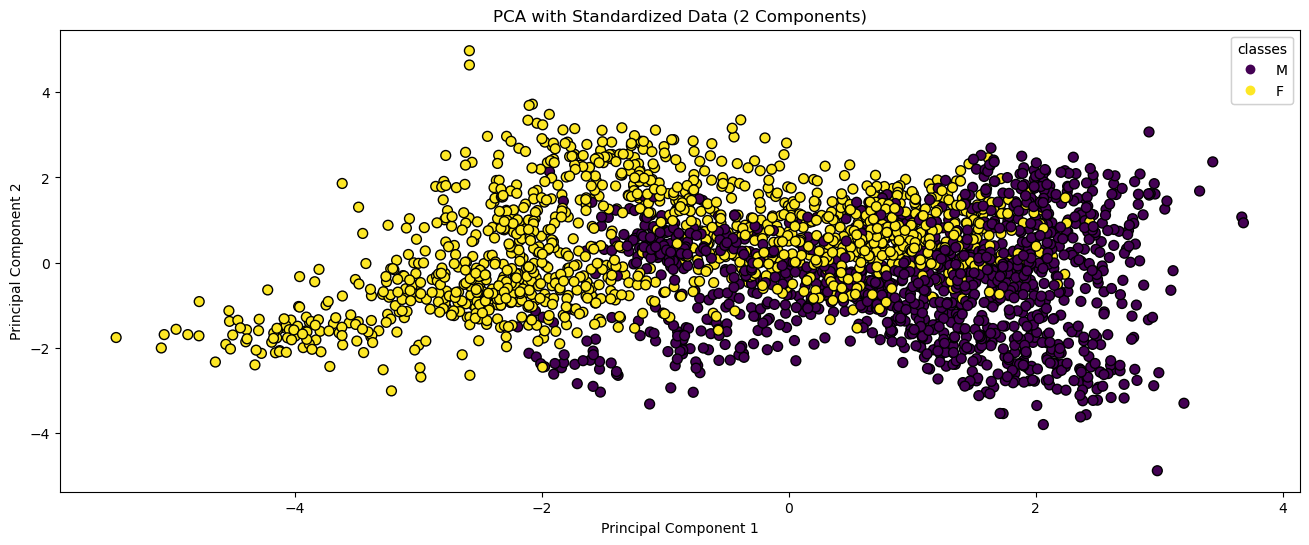

In [25]:
#features distributions - PCA

#mfcc_data holds the whole dataset (both M and F) in a np matrix N_samples x 13 (mfcc)
mfcc_data = np.zeros((len(dataframe_mfcc), n_mfcc))





labels = dataframe_mfcc['sex'].to_numpy()
colors = (labels == 'F').astype(int).tolist()

for i in range(0, len(dataframe_mfcc)):
    mfcc_data[i, :] = np.mean(dataframe_mfcc["mfcc"].iloc[i], axis=1)
#Standardization : mean = 0 and variance = 1. This is done to avoid that features with biggest ranges dominate the decomposition. 
#PCA is sensitive to outliers ! 
z_scaler = StandardScaler()
#Z scaler for training set including outliers
mfcc_standard = z_scaler.fit_transform(mfcc_data)

pca = PCA(n_components=2)
mfcc_reduced = pca.fit_transform(mfcc_standard)
print(pca.explained_variance_ratio_)
print(mfcc_reduced.shape)


fig = plt.figure(1, figsize=(16,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(mfcc_reduced[:, 0], mfcc_reduced[:, 1], c=colors, cmap='viridis', edgecolor='k', s=50)
ax.set(title = "PCA with Standardized Data (2 Components)", xlabel = "Principal Component 1", ylabel = "Principal Component 2")
legend1 = ax.legend(scatter.legend_elements()[0], ['M', 'F'], loc= "upper right", title= "classes")
handles, labels_map = scatter.legend_elements()
print("Labels", labels_map)
ax.add_artist(legend1)
plt.show()


# Classifiers
The classifiers used for baseline are:  
* K-Nearest-Neighboors (KNN) : a simple non-parametric method that classifies based on the similarity of a given feature vector to its nearest neighbors.
* Support Vector Machine (SVM) : More complex classifier that finds an optimal hyperplane maximizing the margin between two classes.

## Training and testing data preparation

In [27]:
#print(speakers.head()) 
speakers_id_total = speakers_flat["speaker_id"].to_list()
sex_total =  speakers_flat["sex"].to_list()


id_train, id_test, _, _ = train_test_split(speakers_id_total, sex_total, test_size=0.33, random_state=42)
train_mfcc_list = []
train_sex_list = []
#Collect train data 

for id_tr_s in id_train: 
    train_cond = speakers_flat[speakers_flat["speaker_id"] == id_tr_s ].index[0]
    single_train_mfcc = speakers_flat.at[train_cond, "mfcc"]
    single_train_sex = speakers_flat.at[train_cond, "sex"]
    arr = np.full(single_train_mfcc.shape[0], single_train_sex)
    train_sex_list.append(arr)
    train_mfcc_list.append(single_train_mfcc)

    

train_sex_array = np.concatenate(train_sex_list)

train_sex_array = (train_sex_array == 'F').astype(int)
train_mfcc_matrix = np.vstack(train_mfcc_list) 

print("Train data shape", train_mfcc_matrix.shape)
print("Train labels shape", train_sex_array.shape)

test_mfcc_list = []
test_sex_list = []


for id_test_s in id_test: 
    test_cond = speakers_flat[speakers_flat["speaker_id"] == id_test_s ].index[0]
    single_test_mfcc = speakers_flat.at[test_cond, "mfcc"]
    single_test_sex = speakers_flat.at[test_cond, "sex"]
    test_arr = np.full(single_test_mfcc.shape[0], single_test_sex)
    test_sex_list.append(test_arr)
    test_mfcc_list.append(single_test_mfcc)

    

test_sex_array = np.concatenate(test_sex_list)

test_sex_array = (test_sex_array == 'F').astype(int)
test_mfcc_matrix = np.vstack(test_mfcc_list) 
print("Test data shape", test_mfcc_matrix.shape)
print("Test labels shape", test_sex_array.shape)






Train data shape (1580, 13)
Train labels shape (1580,)
Test data shape (838, 13)
Test labels shape (838,)


**train_mfcc_matrix** and **train_sex_array** contain train data. The former holds a matrix *N samples x n_mfcc* containing mfcc data for train samples, regarding all the speakers selected for training. The latter, holds the respective array *N_samples* long, holding **1 if the sample corresponds to Female speakers** and **0 if the sample corresponds to Male speaker**. The same operation but considering speakers selected for testing provides **test_mfcc_matrix** and **test_sex_array**. 
Data is standardized, imposing mean 0 and variance 1. This ensures a equal weighting for all features and its crucial for distance-based classifiers.

In [29]:
#STANDARDIZATION

training_scaler = StandardScaler()

X_train_norm = training_scaler.fit_transform(train_mfcc_matrix)
X_test_norm  = training_scaler.transform(test_mfcc_matrix)




## KNN

In [30]:
k = 10 # Choose an optimal value
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train_norm, train_sex_array)


y_pred = knn.predict(X_test_norm)
# Report performance?
# Print evaluation metrics
print("Accuracy:", accuracy_score(test_sex_array, y_pred))
print(classification_report(test_sex_array, y_pred))

Accuracy: 0.7243436754176611
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       515
           1       0.59      0.91      0.72       323

    accuracy                           0.72       838
   macro avg       0.75      0.76      0.72       838
weighted avg       0.79      0.72      0.73       838



## SVM

In [31]:
svm_scaler = StandardScaler()


svm_clf = SVC(kernel='rbf', random_state=42) 

svm_clf.fit(X_train_norm, train_sex_array)

y_pred = svm_clf.predict(X_test_norm)


accuracy = accuracy_score(test_sex_array, y_pred)
print("Accuracy:", accuracy)
print(classification_report(test_sex_array, y_pred))



Accuracy: 0.7816229116945107
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       515
           1       0.64      0.98      0.77       323

    accuracy                           0.78       838
   macro avg       0.81      0.82      0.78       838
weighted avg       0.85      0.78      0.78       838



## Simple Neural Network 
Made only of fully connected layers. No activation functions are used, in order to keep the whole range of variability of the features. The loss "binary_cross_entropy_with_logits" applies internally sigmoid activation function and lightning framework implicitly propagate the loss. During testing sigmoid is explicitly applied.  
You can run the training your self, it's very fast!

In [32]:
#Simple Neural Network 

class SimpleNN(pl.LightningModule):
    def __init__(self, input_size=13):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer with 1 unit (logits)
        self.test_outputs = []
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  
        return x

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)  # BCEWithLogitsLoss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        self.log('val_loss', loss)
        #################
        preds = torch.sigmoid(logits).round()
  
        return {"val_loss": loss}


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits).round() 
        self.test_outputs.append(preds)      






In [33]:


#Split in train and val 
train_data, val_data, train_labels, val_labels =  train_test_split(X_train_norm, train_sex_array, test_size=0.33, random_state=42)

train_data = torch.from_numpy(train_data).to(torch.float32)
val_data = torch.from_numpy(val_data).to(torch.float32)

train_labels = torch.from_numpy(train_labels).to(torch.float32)

train_labels = train_labels.unsqueeze(-1)
val_labels = torch.from_numpy(val_labels).to(torch.float32)

val_labels = val_labels.unsqueeze(-1)

test_data = torch.from_numpy(X_test_norm).to(torch.float32)

test_labels = torch.from_numpy(test_sex_array).to(torch.float32)

test_labels = test_labels.unsqueeze(-1)


train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
# Instantiate the model
model = SimpleNN(n_mfcc)

# Create a Trainer for training and validation
checkpoint = ModelCheckpoint(dirpath='checkpoints_nn/',
                             filename='model-{epoch}-{val_loss: .4f}',
                             monitor='val_loss',
                             save_top_k=3,
                             mode='min')
callbacks = [checkpoint]
trainer = pl.Trainer(max_epochs=50, callbacks = callbacks)

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/silvia/anaconda3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/silvia/Gender Classification/checkpoints_nn exists and is not empty.

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 896    | train
1 | fc2  | Linear | 2.1 K  | train
2 | fc3  | Linear | 33     | train
----------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/silvia/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/silvia/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/silvia/anaconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


**Tensorboard** features allows to visualize training curves. Here, validation loss smoothly decreases. No overfitting is encountered. 

In [34]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/


In [35]:
trainer.test(model, test_loader)

/home/silvia/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

[{}]

In [36]:
test_results = np.concatenate(model.test_outputs)
print("Accuracy:", accuracy_score(test_labels.numpy() , test_results))
print(classification_report(test_labels.numpy() , test_results))


Accuracy: 0.8066825775656324
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.82       515
         1.0       0.69      0.92      0.79       323

    accuracy                           0.81       838
   macro avg       0.81      0.83      0.80       838
weighted avg       0.84      0.81      0.81       838



## Conclusions on 1D classification
It can be seen that higher accuracy is associated to increasing complexity of the classification process. KNN provides the smallest accuracy, being the simpler classifier not really suited to work with highly dimensional features. On the other hand, SVM and the basic Neural Network give similar accuracies.  
In fact, SVM with RBF and a simple neural network can capture non-linear decision boundaries. The RBF kernel in SVM transforms the data into a higher-dimensional space, making complex boundaries more easily separable. A simple neural network does something similar, learning non-linear feature mappings through its hidden layers and activation functions.


# CNN Based classification
For CNN based classification, a whole new set of data handling is required. A dataframe called *speakers_2d* holds speaker_id, gender and a list of mfcc corresponding to the set of features for each sample of that specific speaker. Differently from before, now we have to keep the time information in order to feed a CNN with a set of matrix representing each sample. 

In [62]:



#Dataframe holding the UNIQUE SPEAKERS ID and their sex
speakers_2d = list(set(dataframe_mfcc["speaker_id"]))
#40 different speakers
speakers_2d = dataframe_mfcc.drop_duplicates(subset='speaker_id')[["speaker_id", "sex"]]

speakers_2d["mfcc"] = [[[]] for i in range(0, len(speakers_2d))]
speakers_2d["f0"] = [[] for i in range(0, len(speakers_2d))]





In [78]:

#How are 2d data distribuited for different speakers? 

speakers_list = speakers_flat["speaker_id"].tolist()


for s in speakers_list: 
    samples_speaker = dataframe_mfcc[dataframe_mfcc["speaker_id"]==s]["mfcc"].to_list()
    f0_speaker = dataframe_mfcc[dataframe_mfcc["speaker_id"]==s]["f0"].to_numpy()
    cond_idx = speakers_2d[speakers_2d["speaker_id"] == s ].index[0]
    
    speakers_2d["mfcc"] = speakers_2d["mfcc"].astype('object')
    speakers_2d.at[cond_idx,'mfcc'] =  samples_speaker
    speakers_2d.at[cond_idx, 'f0'] =  f0_speaker
    #print("After assignement: how many samples for ", s, " Speaker : ", speakers.at[cond_idx,'mfcc'])
   


print(speakers_2d.head())




mfcc speakers  72
mfcc speakers  (13, 242)
    speaker_id sex                                               mfcc  \
0         7850   F  [[[2.13033874143318, 2.1263172817312004, 1.887...   
72        3170   M  [[[1.9006099027652326, 2.581504437848311, 2.45...   
121       6313   F  [[[1.7632311101383837, 1.6420039836438787, 1.5...   
217       6241   M  [[[1.803694678764237, 1.6044634251022598, 1.37...   
295       1993   F  [[[0.6132099527766044, 1.0001596828849777, 0.5...   

                                                    f0  
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
72   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
121  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
217  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
295  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  


Speaker_2d column "mfcc" holds, for each speaker, a list of matrices. Each matrix represents the mfcc for a specific audio sample of that speaker.  
These matrices have shape 13 x Nb frame.  
**Variability in audio length is a common problem when dealing with audio as images, and needs to be handled properly.** Typically, the dataset is split into equal length chunks to be handled by a CNN network.